## 第9章: RNN, CNN

### 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ

In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("../chapter06/train.txt", sep="\t")
df_train.head()

,category,title
0,b,Taco Bell reveals 'secret' ingredients of myst...
1,b,RPT-UPDATE 2-Carlyle hires JPMorgan's Cavanagh...
2,b,Argentina Deposits $1 Billion For June 30 Bond...
3,e,Banksy art work showing government agents spyi...
4,e,An acrobatic stunt went horribly wrong on Sund...


In [2]:
from collections import Counter
import re

import nltk
nltk.download('punkt')

# make all titles as one text
text = " ".join(list(df_train["title"]))

# preprocessing
# 1. to lower case
text = text.lower()
# 2. remove some punctuations (..., punc at boundary)
text = " ".join(nltk.word_tokenize(text)) # tokenize
text = re.sub(r"\.\.\.", r"", text) # remove "..."
text = re.sub(r"\b\s\W(\w+\b)", r" \1", text) # remove punc that is in the beginning of any words

freqs = Counter(text.split()).most_common()
tmp_1 = [item[0] for item in freqs if item[1]>=2]
tmp_2 = [item[0] for item in freqs if item[1]<2]
ID_ref = dict(zip(tmp_1, range(1, len(tmp_1)+1))) # words whose id!=0
ID_ref.update(dict(zip(tmp_2, [0]*len(tmp_2)))) # add words whose id=0

# check
list(ID_ref.items())[:100] # invalid punc (ex. : , ') will be ignored in Emb (valid punc ex: $, &)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/anantaprayoon-p/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('to', 1),
 (',', 2),
 ('s', 3),
 ('in', 4),
 ("'", 5),
 ('the', 6),
 ('of', 7),
 ('on', 8),
 ('for', 9),
 ('as', 10),
 (':', 11),
 ('update', 12),
 ('and', 13),
 ('-', 14),
 ('us', 15),
 ('a', 16),
 ('with', 17),
 ('at', 18),
 ('is', 19),
 ('after', 20),
 ('new', 21),
 ('$', 22),
 ('says', 23),
 ('(', 24),
 (')', 25),
 ('from', 26),
 ('up', 27),
 ('?', 28),
 ('by', 29),
 ('kardashian', 30),
 (';', 31),
 ('her', 32),
 ('over', 33),
 ('kim', 34),
 ('it', 35),
 ('be', 36),
 ('1', 37),
 ('``', 38),
 ('&', 39),
 ('china', 40),
 ("''", 41),
 ('stocks', 42),
 ('!', 43),
 ('more', 44),
 ('are', 45),
 ('first', 46),
 ('about', 47),
 ('may', 48),
 ('data', 49),
 ("n't", 50),
 ('will', 51),
 ('shares', 52),
 ('fed', 53),
 ('she', 54),
 ('euro', 55),
 ('not', 56),
 ('that', 57),
 ('ecb', 58),
 ('you', 59),
 ('2', 60),
 ('deal', 61),
 ('out', 62),
 ('sales', 63),
 ('but', 64),
 ('miley', 65),
 ('cyrus', 66),
 ('profit', 67),
 ('global', 68),
 ('rise', 69),
 ('off', 70),
 ('billion', 71),
 ('was',

In [3]:
def get_id(str):
    return [ID_ref[w.lower()] if w.lower() in ID_ref.keys() else 0 for w in str.split()]

# check
get_id("To update time with HogeHoge-kun")

[1, 12, 99, 17, 0]

### 81. RNNによる予測
ID番号で表現された単語列x=(x1,x2,…,xT)
がある．ただし，T
は単語列の長さ，xt∈ℝV
は単語のID番号のone-hot表記である（V
は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列x
からカテゴリy
を予測するモデルを実装せよ．

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

# not consider bidirectionality
class RNN_81(nn.Module):
    def __init__(self, d_in, d_out, d_h, d_w, padding_idx):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h
        self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        # self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=None)
        
        self.rnn = nn.RNN(d_w, d_h, nonlinearity='tanh', bias=True, batch_first=True)
        self.lin = nn.Linear(d_h, d_out, bias=True)
        self.softmax = nn.Softmax(dim=-1) # -1 = last dimension?

    # without pack_padded_sequence
    def forward(self, X):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X)) # one-hot to emb, dim: (B, L, d_V)
        h0 = torch.zeros([1, batch_size, self.d_h], dtype=torch.float) # initial hidden state
        out, h_n = self.rnn(X_emb, h0) # output from each step (unused), final hidden state
        z = self.lin(h_n[0,:,:]) # out[:,-1,:] == h_n[0,:,:] # use h[] when need h from other layers
        # y = self.softmax(z)
        # return y
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot])

# With pack_padded_sequence
class RNN_81_PP(RNN_81):
    def forward(self, X, X_len):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X))
        h0 = torch.zeros([1, batch_size, self.d_h], dtype=torch.float)
        X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False)
        _, h_n = self.rnn(X_packed, h0) # packed seq output, final hidden states
        z = self.lin(h_n[0,:,:])
        # y = self.softmax(z)
        # return y
        return z

### 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [6]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [7]:
# For variable length input (cannot use data.TensorDataset)
class SeqDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y # tensor

    # def __init__(self, X, Y, num_classes):
    #     self.X = to_onehot_bundle(X, num_classes)
    #     self.Y = Y # tensor

    def __getitem__(self, k):
        return self.X[k], self.Y[k]

    def __len__(self):
        return len(self.Y)

# use with RNN_81_PP
class PPSeqDataset(Dataset):
    def __init__(self, X, X_len, Y):
        self.X = X
        self.X_len = X_len
        self.Y = Y # tensor

    def __getitem__(self, k):
        return self.X[k], self.X_len[k], self.Y[k]

    def __len__(self):
        return len(self.Y)

def to_onehot_bundle(X, num_classes):
    out = []
    lengths = []
    for x in X:
        x_id = torch.tensor(get_id(x)).to(torch.int64)
        lengths.append(len(x_id))
        out.append(F.one_hot(x_id, num_classes=num_classes).to(torch.float))

    padded = pad_sequence(out, batch_first=True)
    return padded, torch.tensor(lengths)

In [102]:
def get_acc_pred(pred, y):
    with torch.no_grad(): # not record this in grad calculation
        return (pred.argmax(dim=1)==y).sum() / y.size()[0]

def get_acc(model, nn_type, dataset):
    with torch.no_grad(): # not record this in grad calculation
        loader = DataLoader(dataset, batch_size=1024)
        total = 0.0
        for xb, xb_len, yb in loader:
            xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
            if nn_type=="RNN":
                pred = model(xb, xb_len)
            elif nn_type=="CNN":
                pred = model(xb)
            elif nn_type=="BERT":
                pred = model(xb, xb_len) # xb_len は mask
                # pred = model(xb)
            total += (pred.argmax(dim=1)==yb).sum() 
        
        return total/len(dataset)

def get_loss(model, nn_type, dataset):
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        loader = DataLoader(dataset, batch_size=1024)
        total = 0.0
        for xb, xb_len, yb in loader:
            xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
            if nn_type=="RNN":
                pred = model(xb, xb_len)
            elif nn_type=="CNN":
                pred = model(xb)
            elif nn_type=="BERT":
                pred = model(xb, xb_len) # xb_len は mask
                # pred = model(xb)
            total += loss_fn(pred, yb)
        
        return total/len(loader)

- Approach 1: Without using `packed_padd_sequence`

In [10]:
# # Constants
# N = len(df_train["title"]) # num of training data
# L = 4 # num of labels
# d_V = len(ID_ref) # num of words
# padding_idx = d_V # as ID is from 0 to d_V-1
# B = 1024 # batch size
# N_minibatch = math.ceil(N/B)
# EPOCHS = 20

# # model: RNN_81
# model_82 = RNN_81(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=padding_idx)
# optimizer = torch.optim.SGD(model_82.parameters(), lr=0.01)
# loss_fn = nn.CrossEntropyLoss()

# # variables set-up
# EPOCHS = 10
# acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float)
# loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float)

# # data set-up
# X_train, X_train_len = to_onehot_bundle(df_train["title"], d_V) # padded
# y_train = torch.load("../chapter08/y_train.pt")

# # train_ds = SeqDataset(df_train["title"], torch.load("../chapter08/y_train.pt"), num_classes=d_V)
# train_ds = SeqDataset(X_train, y_train)
# train_dl = DataLoader(train_ds, batch_size=B)

# df_valid = pd.read_csv("../chapter06/valid.txt", sep="\t")
# X_valid, X_valid_len = to_onehot_bundle(df_valid["title"], d_V)
# y_valid = torch.load("../chapter08/y_valid.pt")

# # training
# for epoch in tqdm(range(EPOCHS)):
#     loader = enumerate(train_dl)
#     for batch, (xb, yb) in loader:
#         # prediction and loss calculation
#         pred = model_82(xb)
#         loss = loss_fn(pred, yb)

#         # backpropagation and optimization (SGD)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad():
#             # accumulate loss/acc of training/valid data
#             loss_hist[0, epoch] += loss
#             acc_hist[0, epoch] += get_acc(pred, yb)
#             # loss_hist[1, epoch] += loss_fn(model_82(X_valid), y_valid)
#             # acc_hist[1, epoch] += get_acc(model_82(X_valid), y_valid)

#     with torch.no_grad():
#         # averaging loss/accuracy
#         loss_hist[0, epoch] /= N_minibatch
#         acc_hist[0, epoch] /= N_minibatch
#         # loss_hist[1, epoch] /= N_minibatch
#         # acc_hist[1, epoch] /= N_minibatch

# # plot result
# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(121)
# ax1.set_title("Loss by epoch")
# ax1.plot(range(EPOCHS), loss_hist[0, :].detach().numpy(), label="train")
# # ax1.plot(range(EPOCHS), loss_hist[1, :].detach().numpy(), label="valid")
# plt.legend()

# ax2 = fig.add_subplot(122)
# ax2.set_title("Accuracy by epoch")
# ax2.plot(range(EPOCHS), acc_hist[0, :].detach().numpy(), label="train")
# # ax2.plot(range(EPOCHS), acc_hist[1, :].detach().numpy(), label="valid")
# plt.legend()
# plt.show()


- Approach 2: nn.RNN においてデータに `packed_padd_sequence` をして padding=0 のところを無視して学習させること.

In [9]:
device = torch.device('cpu')

# Constants
N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1

# hyperparameters
B = 32
N_minibatch = math.ceil(N/B)
EPOCHS = 10

# data set-up
X_train, X_train_len = to_onehot_bundle(df_train["title"], d_V) # padded
y_train = torch.load("../chapter08/y_train.pt")

train_ds = PPSeqDataset(X_train, X_train_len, y_train)
train_dl = DataLoader(train_ds, batch_size=B)

df_valid = pd.read_csv("../chapter06/valid.txt", sep="\t")
X_valid, X_valid_len = to_onehot_bundle(df_valid["title"], d_V)
y_valid = torch.load("../chapter08/y_valid.pt")
valid_ds = PPSeqDataset(X_valid, X_valid_len, y_valid)

100%|██████████| 10/10 [01:34<00:00,  9.48s/it]


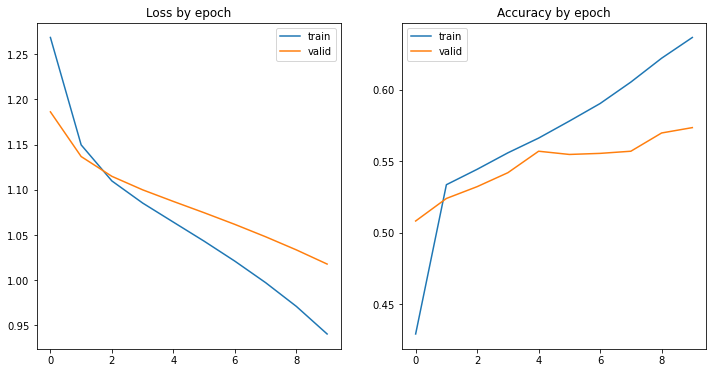

train loss: 0.94048, train acc: 0.63641
valid loss: 1.01782, valid acc: 0.57346


In [10]:
# model: RNN_81_PP (try using nn.rnn.pack_padded_sequence)
model_82_PP = RNN_81_PP(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=padding_idx)
optimizer = torch.optim.SGD(model_82_PP.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float)
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        # prediction and loss calculation
        pred = model_82_PP(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation and optimization (SGD)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        loss_hist[1, epoch] = get_loss(model_82_PP, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_82_PP, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title("Loss by epoch")
ax1.plot(range(EPOCHS), loss_hist[0, :].detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title("Accuracy by epoch")
ax2.plot(range(EPOCHS), acc_hist[0, :].detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B
事例ごとに損失・勾配を計算して学習を行えるようにせよ（B
の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [12]:
# check access to gpu
print(torch.cuda.is_available())
!nvidia-smi

True
Mon Jul  4 11:47:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 29%   39C    P8    32W / 250W |   9606MiB / 11011MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 3

In [12]:
# model
# despite model.to(cuda), newly declared torch obj should be transferred to CUDA manually
class RNN_83(nn.Module):
    def __init__(self, d_in, d_out, d_h, d_w, padding_idx, device):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h
        self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)

        self.rnn = nn.RNN(d_w, d_h, nonlinearity='tanh', bias=True, batch_first=True)
        self.lin = nn.Linear(d_h, d_out, bias=True)
        self.softmax = nn.Softmax(dim=-1)

        self.device = device

    def forward(self, X, X_len):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X))
        h0 = torch.zeros([1, batch_size, self.d_h], dtype=torch.float).to(self.device)
        X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False) # to device?
        _, h_n = self.rnn(X_packed, h0) # packed seq output, final hidden states r
        z = self.lin(h_n[0,:,:])
        # y = self.softmax(z)
        # return y
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

- Approach 1: Without using `packed_padd_sequence`

In [12]:
# ## CUDA device
# device = torch.device("cuda:1")

# ## variables set-up
# # mini-batch
# EPOCHS = 10
# B = 1024

# N = len(df_train["title"]) # num of training data
# L = 4 # num of labels
# d_V = len(ID_ref) # num of words
# padding_idx = d_V # as ID is from 0 to d_V-1
# N_minibatch = math.ceil(N/B)

# # data set-up
# # move training, validation data to CUDA
# X_train, X_train_len = to_onehot_bundle(df_train["title"], d_V) # padded
# y_train = torch.load("../chapter08/y_train.pt")
# train_ds = SeqDataset(X_train, y_train)
# train_dl = DataLoader(train_ds, batch_size=B)

# df_valid = pd.read_csv("../chapter06/valid.txt", sep="\t")
# X_valid, X_valid_len = to_onehot_bundle(df_valid["title"], d_V)
# y_valid = torch.load("../chapter08/y_valid.pt").to(device)

# # model
# model_83 = RNN_83(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device).to(device)
# optimizer = torch.optim.SGD(model_83.parameters(), lr=0.01)
# loss_fn = nn.CrossEntropyLoss()

# # training
# loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
# acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
# for epoch in tqdm(range(EPOCHS)):
#     loader = enumerate(train_dl)
#     for batch, (xb, yb) in loader:
#     # for xb, yb in train_dl:
#         xb, yb = xb.to(device), yb.to(device)
#         pred = model_83(xb)
#         loss = loss_fn(pred, yb)

#         # backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         with torch.no_grad():
#             # accumulate loss/acc of training/valid data
#             loss_hist[0, epoch] += loss
#             acc_hist[0, epoch] += get_acc(pred, yb)
#             loss_hist[1, epoch] += loss_fn(model_83(X_valid), y_valid)
#             acc_hist[1, epoch] += get_acc(model_83(X_valid), y_valid)

#     with torch.no_grad():
#         # averaging loss/accuracy
#         loss_hist[0, epoch] = loss_hist[0, epoch] / N_minibatch
#         acc_hist[0, epoch] = acc_hist[0, epoch] / N_minibatch
#         loss_hist[1, epoch] = loss_hist[1, epoch] / N_minibatch
#         acc_hist[1, epoch] = acc_hist[1, epoch] / N_minibatch

# # plot result
# fig = plt.figure(figsize=(12, 6))
# ax1 = fig.add_subplot(121)
# ax1.set_title(f"Loss by epoch (Batch size = {B})")
# ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
# ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
# plt.legend()

# ax2 = fig.add_subplot(122)
# ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
# ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
# ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
# plt.legend()

# plt.show()

- Approach 2: Use `packed_padd_sequence`

In [13]:
## CUDA device
device = torch.device("cuda:1")

# hyperparameters
EPOCHS = 10
B = 32

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


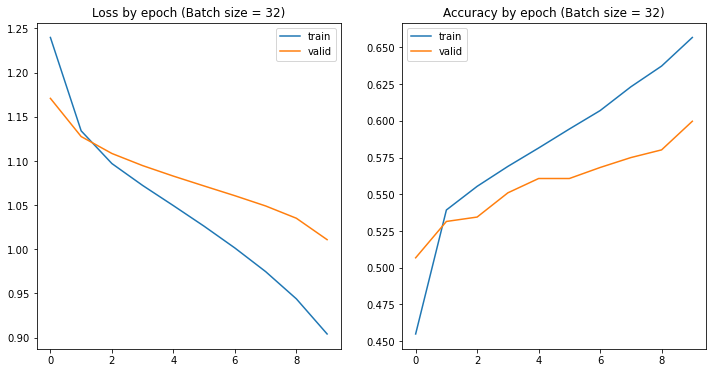

train loss: 0.90418, train acc: 0.65672
valid loss: 1.01092, valid acc: 0.59970


In [13]:
# model
model_83_PP = RNN_83(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device).to(device)
optimizer = torch.optim.SGD(model_83_PP.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
    # for xb, yb in train_dl:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_83_PP(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy training data
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_83_PP, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_83_PP, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込みemb(x)
を初期化し，学習せよ．

In [14]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format("../chapter08/GoogleNews-vectors-negative300.bin", binary=True)

In [15]:
# from given pretrained embeddings, get only the embeddings of tokens in training data
def mod_emb(pre_emb, id_ref, padding_idx):
    d_V = len(id_ref)
    d_w = pre_emb.vector_size
    emb = torch.ones(()).new_empty((d_V+1, d_w)) # must be 2-dimensional FloatTensor (d_V+1, d_w), device=None
    emb[padding_idx] = torch.zeros((1, d_w))

    # for each word of an id, get the embedding
    # unk(idx=0) + non-existed key in pre-emb will be remained as randomized values
    for token in id_ref:
        try:
            v = np.copy(pre_emb[token]) # need writable vec so get a copied one
            emb[id_ref[token]] = torch.from_numpy(v)
        except KeyError:
            pass # non-existed key id_ref[id]
    
    return emb

mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)

tensor([[-1.9531e-02,  1.5332e-01,  9.4604e-03,  ...,  4.8242e-01,
         -2.5024e-02, -1.6895e-01],
        [ 2.7632e-40,  1.3349e-40,         nan,  ...,  3.7989e-40,
          1.9297e-40,  4.5909e-40],
        [ 2.2105e-40,  8.7762e-41,         nan,  ...,  4.3457e-40,
          2.6523e-40,  1.2602e-40],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

In [16]:
class RNN_84(nn.Module):
    def __init__(self, d_in, d_out, d_h, d_w, padding_idx, device, pretrained_emb=None):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h

        # Embedding
        if pretrained_emb == None:
            self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=padding_idx, freeze=True) # should we train this? (if yes, set freeze=False)

        self.rnn = nn.RNN(d_w, d_h, nonlinearity='tanh', bias=True, batch_first=True)
        self.lin = nn.Linear(d_h, d_out, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        self.device = device

    def forward(self, X, X_len):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X))
        h0 = torch.zeros([1, batch_size, self.d_h], dtype=torch.float).to(self.device)
        X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False) # to device?
        _, h_n = self.rnn(X_packed, h0) # packed seq output, final hidden states
        z = self.lin(h_n[0,:,:])
        # y = self.softmax(z)
        # return y
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

100%|██████████| 10/10 [01:24<00:00,  8.43s/it]


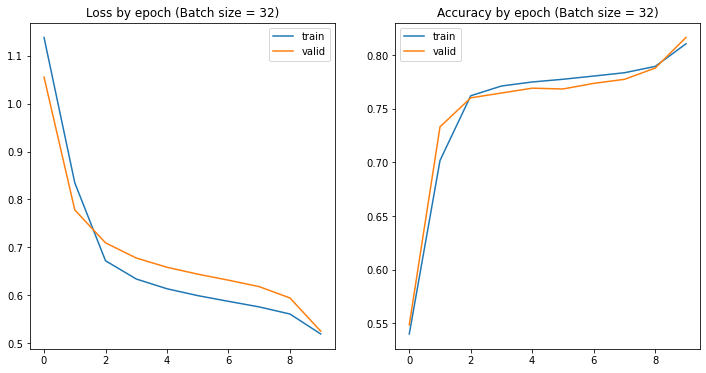

train loss: 0.51931, train acc: 0.81044
valid loss: 0.52515, valid acc: 0.81634


In [19]:
## CUDA device
device = torch.device("cuda:1")

## variables set-up
# mini-batch
EPOCHS = 10
B = 32

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_84 = RNN_84(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb).to(device)
optimizer = torch.optim.SGD(model_84.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_84(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_84, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_84, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．さらに，双方向RNNを多層化して実験せよ．

参考

output, n_h = nn.RNN(x, h0) を nn.Linear に入力するときに
- output 使う場合：https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66 (en), https://qiita.com/m__k/items/78a5125d719951ca98d3 (jp)
- h_n 使う場合：https://discuss.pytorch.org/t/bidirectional-3-layer-lstm-hidden-output/41336/4

In [17]:
from torch.nn.utils.rnn import pad_packed_sequence

class RNN_85(nn.Module):
    def __init__(self, d_in, d_out, d_h, d_w, padding_idx, device, pretrained_emb=None, num_layers=1, bidirectional=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h

        # Embedding
        if pretrained_emb == None:
            self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=padding_idx, freeze=True) # should we train this? (if yes, set freeze=False)

        # added: bidirectionality, num_layers
        self.bidirectional = bidirectional
        self.D = 2 if bidirectional==True else 1
        self.num_layers = num_layers

        self.rnn = nn.RNN(d_w, d_h, nonlinearity='tanh', bias=True, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.lin = nn.Linear(d_h*self.D, d_out, bias=True) # generalize input dim
        self.softmax = nn.Softmax(dim=-1)
        self.device = device

    def forward(self, X, X_len):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X))
        h_0 = torch.zeros([self.D*self.num_layers, batch_size, self.d_h], dtype=torch.float).to(self.device) # generalize h0 dim
        X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False)
        packed_output, h_n = self.rnn(X_packed, h_0) # packed seq output, final hidden states
        # output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
        if self.bidirectional:
            # z = self.lin(torch.cat((h_n[0,:,:], h_n[1,:,:]), dim=1)) # work?
            # z = self.lin(torch.cat((output[:, -1, :self.d_h], output[:, 0, self.d_h:]), dim=1))
            h_n_re = h_n.view(self.D, self.num_layers, batch_size, self.d_h)
            z = self.lin(torch.cat((h_n_re[0,-1,:,:], h_n_re[1,-1,:,:]), dim=1))
        else:
            # z = self.lin(output[:, -1, :self.d_h])
            z = self.lin(h_n[0,:,:])
        # y = self.softmax(z)
        # return y
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

100%|██████████| 10/10 [01:25<00:00,  8.59s/it]


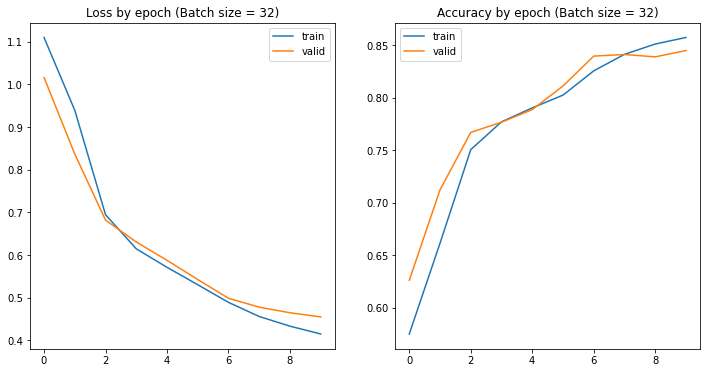

train loss: 0.41525, train acc: 0.85732
valid loss: 0.45533, valid acc: 0.84483


In [21]:
## CUDA device
device = torch.device("cuda:1")

## variables set-up
# mini-batch
EPOCHS = 10
B = 32

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_85 = RNN_85(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True).to(device)
optimizer = torch.optim.SGD(model_85.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_85(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_85, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_85, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

- 多層化 (num_layers=3)

100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


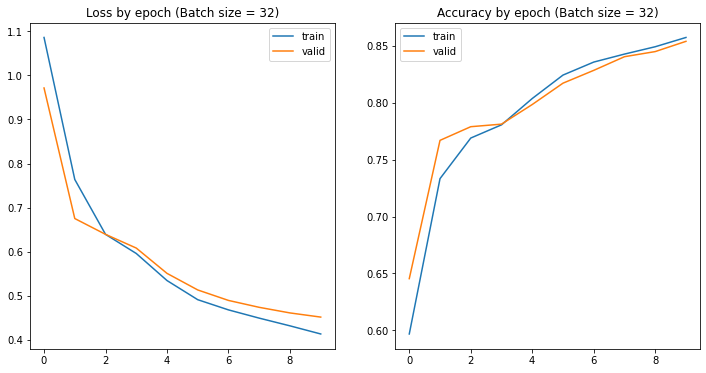

train loss: 0.41295, train acc: 0.85722
valid loss: 0.45128, valid acc: 0.85382


In [22]:
## CUDA device
device = torch.device("cuda:1")

## variables set-up
# mini-batch
EPOCHS = 10
B = 32

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# data set-up
# move training, validation data to CUDA
X_train, X_train_len = to_onehot_bundle(df_train["title"], d_V) # padded
y_train = torch.load("../chapter08/y_train.pt")
train_ds = PPSeqDataset(X_train, X_train_len, y_train)
train_dl = DataLoader(train_ds, batch_size=B)

df_valid = pd.read_csv("../chapter06/valid.txt", sep="\t")
X_valid, X_valid_len = to_onehot_bundle(df_valid["title"], d_V)
y_valid = torch.load("../chapter08/y_valid.pt").to(device)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_85_2 = RNN_85(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True, num_layers=3).to(device)
optimizer = torch.optim.SGD(model_85_2.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_85_2(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_85_2, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_85_2, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 86. 畳み込みニューラルネットワーク (CNN)

In [18]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, d_in, d_out, d_w, d_h, padding_idx, device, kernel_size, stride, conv_padding, pretrained_emb=None):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h
        self.device = device

        # Embedding
        if pretrained_emb == None:
            self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=padding_idx, freeze=True)

        # Layers
        self.conv = nn.Conv1d(in_channels=d_w, out_channels=d_h, kernel_size=kernel_size, stride=stride, padding=conv_padding, bias=True)
        self.act = nn.ReLU()
        self.lin = nn.Linear(d_h, d_out, bias=True)
        self.softmax = nn.Softmax(dim=-1)


    # def forward(self, X, X_len):
    def forward(self, X):
        # B = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X)) # dim_out: (B, L, d_w)
        # X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False)
        conv_out = self.conv(X_emb.transpose(1,2)) # dim_in: (B, d_w, L_in), dim_out: (B, d_h, L_out)
        p = self.act(conv_out)
        c = F.max_pool1d(p, kernel_size=p.size()[2]) # dim_out: (B, d_h, 1)
        z = self.lin(c.squeeze(dim=2)) # dim_in: (B, d_h), output dim_out: (B, L=4)
        # y = self.softmax(z)
        # return y
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

In [24]:
# check: predict first few training data
device = torch.device("cuda:1")
model = CNN(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, kernel_size=3, stride=1, conv_padding=0).to(device)
nn.Softmax(dim=1)(model(X_train[:5]))

tensor([[0.2335, 0.3156, 0.2227, 0.2282],
        [0.2422, 0.2823, 0.2364, 0.2391],
        [0.2292, 0.3127, 0.2241, 0.2340],
        [0.2453, 0.2684, 0.2432, 0.2431],
        [0.2552, 0.2990, 0.2247, 0.2211]], device='cuda:1',
       grad_fn=<SoftmaxBackward0>)

### 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

note: 結構不安定（時々学習にならなず、loss がnanになって acc が変化しない softmax使わないため？）

100%|██████████| 10/10 [01:20<00:00,  8.00s/it]


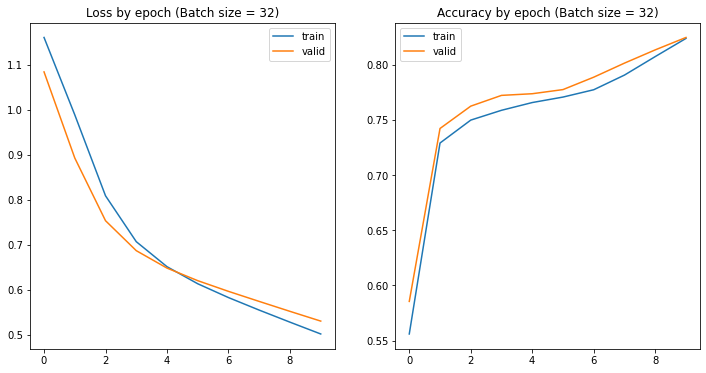

train loss: 0.50166, train acc: 0.82373
valid loss: 0.53030, valid acc: 0.82459


In [21]:
## CUDA device
device = torch.device("cuda:1")

## variables set-up
# mini-batch
EPOCHS = 10
B = 32

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_86 = CNN(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, kernel_size=3, stride=1, conv_padding='same', pretrained_emb=pretrained_emb).to(device)
optimizer = torch.optim.SGD(model_86.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        # pred = model_86(xb, xb_len)
        pred = model_86(xb)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)  

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_86, "CNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_86, "CNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

#### 試し

NN 形状:
- ReLU vs tanh
- pretrained_emb も学習させる(freeze=False)
- CNN: Pooling type, conv. layers

hyperparameter: d_h, lr, batch size, epoch数

etc: optimizer type (Adam)

#### RNN の改変
まとめ：
- num_layer=2,3,5,10 のなかで 2 が一番良い
- optim.Adam の lr=0.001 で過学習になった
- 双方向の隠れ状態の結合を各要素の和に置き換えてみると、少しだけ良くなるが linear 層の parameter (W の次元) が減らせる
- best perf: RNN num_layers=2, lr=0.01, SGD, 双方向 element-wise addition (2番目の結果)

結果：
1. num_layers=2, epochs=50

100%|██████████| 50/50 [07:23<00:00,  8.87s/it]


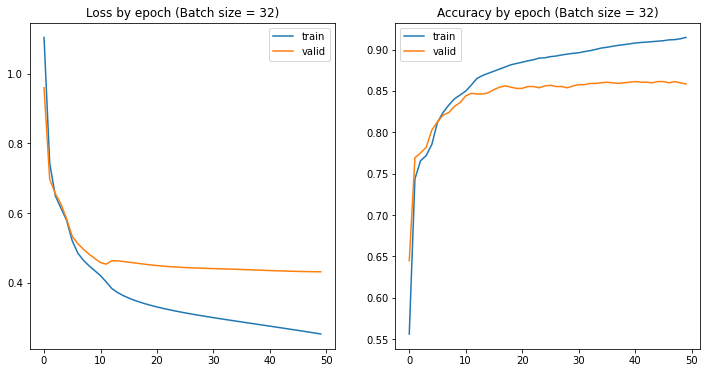

train loss: 0.25327, train acc: 0.91467
valid loss: 0.43171, valid acc: 0.85832


In [27]:
# hyperparameter
num_layers = 2
EPOCHS = 50
B = 32
lr = 0.01 # SGD

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_1 = RNN_85(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True, num_layers=num_layers).to(device)
optimizer = torch.optim.SGD(model_88_1.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_88_1(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_1, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_1, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")  

2. 双方向の隠れ層表現を element-wise addition で分類機に入力

In [30]:
class RNN_rev(nn.Module):
    def __init__(self, d_in, d_out, d_h, d_w, padding_idx, device, pretrained_emb=None, num_layers=1, bidirectional=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h

        # Embedding
        if pretrained_emb == None:
            self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=padding_idx, freeze=True) # should we train this? (if yes, set freeze=False)

        # added: bidirectionality, num_layers
        self.bidirectional = bidirectional
        self.D = 2 if bidirectional==True else 1
        self.num_layers = num_layers

        self.rnn = nn.RNN(d_w, d_h, nonlinearity='tanh', bias=True, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.lin = nn.Linear(d_h, d_out, bias=True)
        self.softmax = nn.Softmax(dim=-1)
        self.device = device

    def forward(self, X, X_len):
        batch_size = X.size()[0]
        X_emb = self.emb(self.onehot2ids(X))
        h_0 = torch.zeros([self.D*self.num_layers, batch_size, self.d_h], dtype=torch.float).to(self.device) # generalize h0 dim
        X_packed = pack_padded_sequence(X_emb, lengths=list(X_len), batch_first=True, enforce_sorted=False)
        packed_output, h_n = self.rnn(X_packed, h_0) # packed seq output, final hidden states
        if self.bidirectional:
            h_n_re = h_n.view(self.D, self.num_layers, batch_size, self.d_h)
            z = self.lin(torch.add(h_n_re[0,-1,:,:], h_n_re[1,-1,:,:]))
        else:
            z = self.lin(h_n[0,:,:])
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

100%|██████████| 50/50 [07:20<00:00,  8.82s/it]


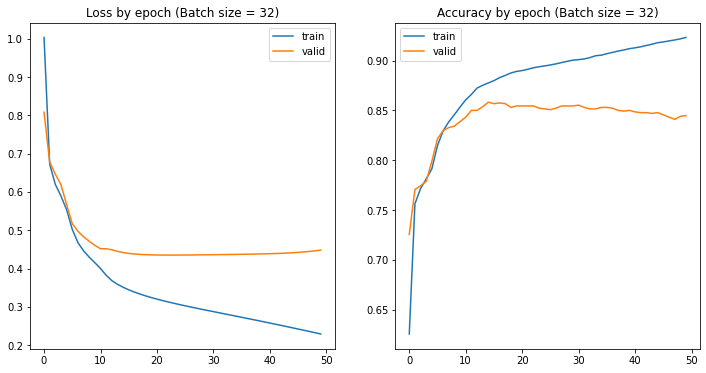

train loss: 0.22924, train acc: 0.92328
valid loss: 0.44807, valid acc: 0.84483


In [32]:
# hyperparameter
num_layers = 2
EPOCHS = 50
B = 32
lr = 0.01 # SGD

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_1 = RNN_rev(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True, num_layers=num_layers).to(device)
optimizer = torch.optim.SGD(model_88_1.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_88_1(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_1, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_1, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")  

3. num_layers=2, epoch=50, lr=0.1, (SGD) → 過学習

100%|██████████| 50/50 [07:24<00:00,  8.89s/it]


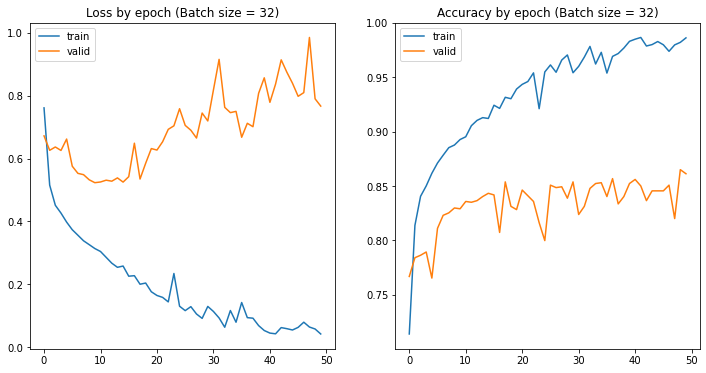

train loss: 0.04138, train acc: 0.98625
valid loss: 0.76685, valid acc: 0.86132


In [36]:
# hyperparameter
num_layers = 2
EPOCHS = 50
B = 32
lr = 0.1 # SGD

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_2 = RNN_85(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True, num_layers=num_layers).to(device)
optimizer = torch.optim.SGD(model_88_2.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_88_2(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_2, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_2, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")  

4. Optimizer: Adam (lr = 0.001) → 過学習

100%|██████████| 50/50 [07:40<00:00,  9.20s/it]


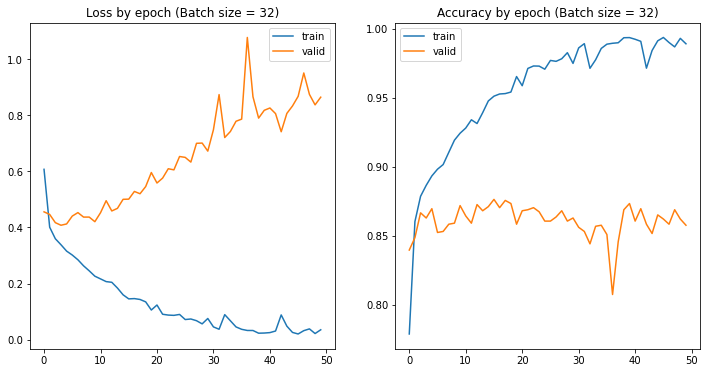

train loss: 0.03517, train acc: 0.98915
valid loss: 0.86393, valid acc: 0.85757


In [31]:
# hyperparameter
num_layers = 2
EPOCHS = 50
B = 32
lr = 0.001 # Adam

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_3 = RNN_85(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, pretrained_emb=pretrained_emb, bidirectional=True, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model_88_3.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        pred = model_88_3(xb, xb_len)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_3, "RNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_3, "RNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")  

#### CNN の改変
まとめ：
- optim.SGD の場合: max pooling を avg pooling に置き換えるとあまり
- optim.Adam の場合：max pooling の方は過学習になっていて、
- best: Adam, Avg pooling ? valid loss は上がりそうだが...

結果：
1. SGD, Avg pooling

In [36]:
class CNN_rev(nn.Module):
    def __init__(self, d_in, d_out, d_w, d_h, padding_idx, device, kernel_size, stride, conv_padding, pretrained_emb=None):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.d_w = d_w
        self.d_h = d_h
        self.device = device

        # Embedding
        if pretrained_emb == None:
            self.emb = nn.Embedding(num_embeddings=d_in+1, embedding_dim=d_w, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding.from_pretrained(pretrained_emb, padding_idx=padding_idx, freeze=True)

        # Layers
        self.conv = nn.Conv1d(in_channels=d_w, out_channels=d_h, kernel_size=kernel_size, stride=stride, padding=conv_padding, bias=True)
        self.act = nn.ReLU()
        self.lin = nn.Linear(d_h, d_out, bias=True)
        # self.softmax = nn.Softmax(dim=-1)


    def forward(self, X):
        X_emb = self.emb(self.onehot2ids(X)) # dim_out: (B, L, d_w)
        conv_out = self.conv(X_emb.transpose(1,2)) # dim_in: (B, d_w, L_in), dim_out: (B, d_h, L_out)
        p = self.act(conv_out)
        # c = F.max_pool1d(p, kernel_size=p.size()[2]) # dim_out: (B, d_h, 1)
        c = F.avg_pool1d(p, kernel_size=p.size()[2])
        z = self.lin(c.squeeze(dim=2)) # dim_in: (B, d_h), output dim_out: (B, L=4)
        return z

    # extend for varying batch sizes
    def onehot2ids(self, X_onehot):
        return torch.tensor([[torch.argmax(v) for v in x] for x in X_onehot]).to(self.device)

100%|██████████| 50/50 [06:39<00:00,  7.99s/it]


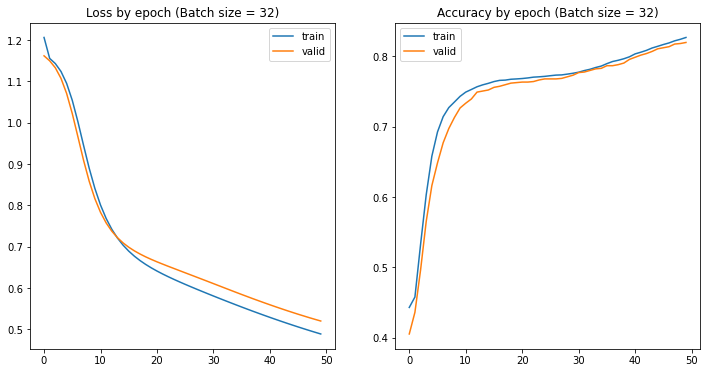

train loss: 0.48890, train acc: 0.82644
valid loss: 0.52027, valid acc: 0.81934


In [35]:
# hyperparameter
EPOCHS = 50
B = 32
lr = 0.01 # SGD

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_4 = CNN_rev(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, kernel_size=3, stride=1, conv_padding='same', pretrained_emb=pretrained_emb).to(device)
optimizer = torch.optim.SGD(model_88_4.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        # pred = model_86(xb, xb_len)
        pred = model_88_4(xb)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_4, "CNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_4, "CNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

2. Adam, Max Pooling → 過学習

100%|██████████| 20/20 [02:42<00:00,  8.12s/it]


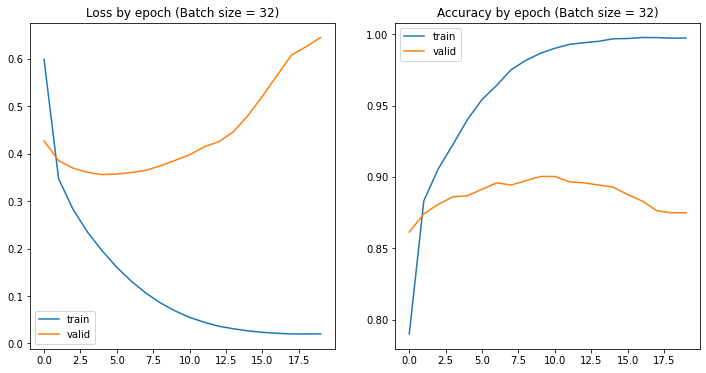

train loss: 0.02011, train acc: 0.99738
valid loss: 0.64517, valid acc: 0.87481


In [40]:
# hyperparameter
EPOCHS = 20
B = 32
# lr = 0.01 # Adam

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_4 = CNN(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, kernel_size=3, stride=1, conv_padding='same', pretrained_emb=pretrained_emb).to(device)
optimizer = torch.optim.Adam(model_88_4.parameters())
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        # pred = model_86(xb, xb_len)
        pred = model_88_4(xb)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_4, "CNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_4, "CNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

3. Adam, Avg pooling

100%|██████████| 50/50 [06:44<00:00,  8.08s/it]


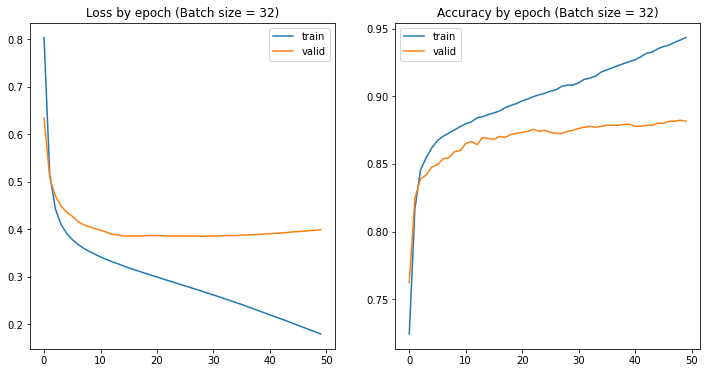

train loss: 0.17968, train acc: 0.94349
valid loss: 0.39935, valid acc: 0.88156


In [41]:
# hyperparameter
EPOCHS = 50
B = 32
# lr = 0.01 # Adam

N = len(df_train["title"]) # num of training data
L = 4 # num of labels
d_V = len(ID_ref) # num of words
padding_idx = d_V # as ID is from 0 to d_V-1
N_minibatch = math.ceil(N/B)

# model
pretrained_emb = mod_emb(word_vectors, ID_ref, padding_idx=padding_idx)
model_88_4 = CNN_rev(d_in=d_V, d_out=L, d_h=50, d_w=300, padding_idx=d_V, device=device, kernel_size=3, stride=1, conv_padding='same', pretrained_emb=pretrained_emb).to(device)
optimizer = torch.optim.Adam(model_88_4.parameters())
loss_fn = nn.CrossEntropyLoss()

# training
loss_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
acc_hist = torch.zeros([2, EPOCHS], dtype=torch.float).to(device)
for epoch in tqdm(range(EPOCHS)):
    loader = enumerate(train_dl)
    for batch, (xb, xb_len, yb) in loader:
        xb, xb_len, yb = xb.to(device), xb_len.to(device), yb.to(device)
        # pred = model_86(xb, xb_len)
        pred = model_88_4(xb)
        loss = loss_fn(pred, yb)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # accumulate loss/acc of training/valid data
            loss_hist[0, epoch] += loss
            acc_hist[0, epoch] += get_acc_pred(pred, yb)

    with torch.no_grad():
        # averaging loss/accuracy
        loss_hist[0, epoch] /= N_minibatch
        acc_hist[0, epoch] /= N_minibatch
        # valid data loss/acc
        loss_hist[1, epoch] = get_loss(model_88_4, "CNN", valid_ds)
        acc_hist[1, epoch] = get_acc(model_88_4, "CNN", valid_ds)

# plot result
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.set_title(f"Loss by epoch (Batch size = {B})")
ax1.plot(range(EPOCHS), loss_hist[0, :].cpu().detach().numpy(), label="train")
ax1.plot(range(EPOCHS), loss_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()

ax2 = fig.add_subplot(122)
ax2.set_title(f"Accuracy by epoch (Batch size = {B})")
ax2.plot(range(EPOCHS), acc_hist[0, :].cpu().detach().numpy(), label="train")
ax2.plot(range(EPOCHS), acc_hist[1, :].cpu().detach().numpy(), label="valid")
plt.legend()
plt.show()

print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")

### 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

note: BertModel の使い方の例では model(**input) のように入力入れたけどそうみたいに実装することはまだできない。（今は model(input_arg1, input_arg2) のようにした）
https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel.forward.example

In [3]:
# !pip install transformers

In [77]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

from transformers import BertTokenizer, BertModel, AdamW

In [74]:
# try using BertModel
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

text = ["Taco Bell reveals 'secret' ingredients of mystery beef that's 88 per cent cow", "RPT-UPDATE 2-Carlyle hires JPMorgan's Cavanagh as co-president"]
inputs = tokenizer(text, return_tensors='pt', padding=True)
outputs = model(**inputs)

outputs.last_hidden_state

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[[-0.5998,  0.2662,  0.1373,  ..., -0.2155,  0.6171,  0.1324],
         [ 0.4531, -0.2538,  0.3637,  ..., -0.0104,  0.8298, -0.1252],
         [-0.2088,  0.3360,  0.3908,  ...,  0.3247,  0.5475, -0.1559],
         ...,
         [-0.0908, -0.0214,  0.1715,  ...,  0.1642,  0.3818, -0.1365],
         [-0.1320, -0.1390,  0.0803,  ...,  0.1888,  0.4830, -0.3153],
         [ 0.0949, -0.0441,  0.1552,  ...,  0.1193,  0.3760, -0.2103]],

        [[-1.1457,  0.0910, -0.2610,  ..., -0.4974,  0.3982,  0.4919],
         [-0.4513, -0.7068,  0.2365,  ..., -0.0970,  0.5946,  0.1901],
         [-0.4150, -0.2491,  0.6926,  ..., -0.2325,  0.3210, -0.5595],
         ...,
         [-0.8312, -0.0810,  0.3973,  ..., -0.4181,  0.0808, -0.2792],
         [-0.8164, -0.1279, -0.5725,  ..., -0.6381,  0.5551,  0.1341],
         [ 0.5368,  0.2440, -0.1652,  ..., -0.0672, -0.4246, -0.0898]]],
       grad_fn=<NativeLayerNormBackward0>)

In [100]:
class BertDataset(Dataset):
    def __init__(self, X, Y, tokenizer):
        self.X = X # list of titles
        self.Y = Y
        self.tokenizer = tokenizer
        self.max_length = len(tokenizer(X, return_tensors="pt", padding=True)['input_ids'][0])

    def __getitem__(self, k):
        X_k = self.tokenizer(self.X[k], return_tensors="pt", padding="max_length", max_length=self.max_length)
        return X_k['input_ids'], X_k['attention_mask'], self.Y[k]
    
    def __len__(self):
        return len(self.Y)

# data preparation
X_train = list(pd.read_csv("../chapter06/train.txt", sep="\t")["title"])
y_train = torch.load("../chapter08/y_train.pt")
X_valid = list(pd.read_csv("../chapter06/valid.txt", sep="\t")["title"])
y_valid = torch.load("../chapter08/y_valid.pt")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_ds_bert = BertDataset(X_train, y_train, tokenizer)
valid_ds_bert = BertDataset(X_valid, y_valid, tokenizer)

In [101]:
class BertClassifier(nn.Module):
    def __init__(self, d_out):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(768, d_out, bias=True)

    def forward(self, X, mask):
        X = torch.squeeze(X, dim=1) # remove 1 at 2nd dim
        out = self.bert(input_ids=X, attention_mask=mask)
        z = self.fc(out.last_hidden_state[:,-1,:])
        return z
        
def train_bert(train_ds, valid_ds, model, optimizer, loss_fn, epochs, batch_size):
    train_dl = DataLoader(train_ds, batch_size=batch_size)
    loss_fn = nn.CrossEntropyLoss()
    loss_hist = torch.zeros([2, epochs], dtype=torch.float).to(device)
    acc_hist = torch.zeros([2, epochs], dtype=torch.float).to(device)
    N_minibatch = math.ceil(len(train_ds)/B)
    
    model.to(device)
    model.train()
    for epoch in tqdm(range(epochs)):
        loader = enumerate(train_dl)
        for batch, (xb, mask, yb) in loader:
            xb, mask, yb = xb.to(device), mask.to(device), yb.to(device)
            pred = model(xb, mask)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # accumulate loss/acc of training/valid data
                loss_hist[0, epoch] += loss
                acc_hist[0, epoch] += get_acc_pred(pred, yb)

        with torch.no_grad():
            # averaging training data's loss/accuracy
            loss_hist[0, epoch] /= N_minibatch
            acc_hist[0, epoch] /= N_minibatch
            # valid data loss/acc
            loss_hist[1, epoch] = get_loss(model, "BERT", valid_ds)
            acc_hist[1, epoch] = get_acc(model, "BERT", valid_ds)

    return loss_hist, acc_hist

def plot_result(loss_hist, acc_hist):
    EPOCHS = loss_hist.size()[1]
    if device.type != 'cpu':
        loss_hist = loss_hist.cpu().detach().numpy()
    if device.type != 'cpu':
        acc_hist = acc_hist.cpu().detach().numpy()

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121)
    ax1.set_title(f"Loss by epoch")
    ax1.plot(np.arange(1, EPOCHS+1), loss_hist[0, :], label="train")
    ax1.plot(np.arange(1, EPOCHS+1), loss_hist[1, :], label="valid")
    plt.legend()

    ax2 = fig.add_subplot(122)
    ax2.set_title(f"Accuracy by epoch")
    ax2.plot(np.arange(1, EPOCHS+1), acc_hist[0, :], label="train")
    ax2.plot(np.arange(1, EPOCHS+1), acc_hist[1, :], label="valid")
    plt.legend()
    plt.show()

In [ ]:
# torch.cuda.empty_cache()
# !nvidia-smi

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [05:17<00:00, 31.73s/it]


train loss: 0.15763, train acc: 0.94723
valid loss: 0.24633, valid acc: 0.92279


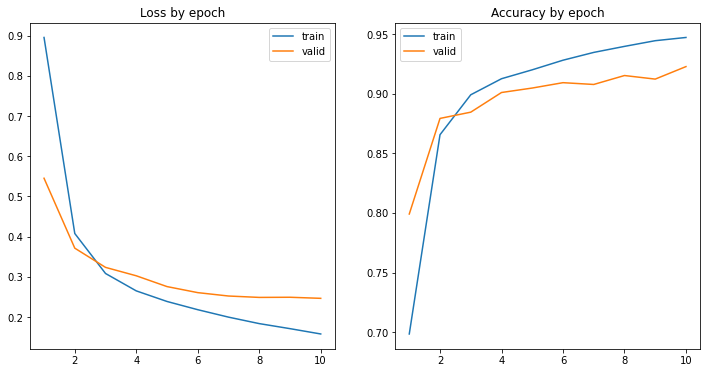

In [105]:
device = torch.device("cuda:1")

model_89 = BertClassifier(d_out=4)
optimizer = AdamW(model_89.parameters(), lr=1e-6)
loss_fn = nn.CrossEntropyLoss()

loss_hist, acc_hist = train_bert(train_ds_bert, valid_ds_bert, model_89, optimizer, loss_fn, epochs=10, batch_size=32)
print(f"train loss: {loss_hist[0, -1]:.5f}, train acc: {acc_hist[0, -1]:.5f}")
print(f"valid loss: {loss_hist[1, -1]:.5f}, valid acc: {acc_hist[1, -1]:.5f}")
plot_result(loss_hist, acc_hist)